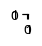

In [2]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
f,a = plt.subplots(1,1,figsize=(1e-2, 1e-2))
mpl.rcParams['figure.dpi'] = 150
sns.set_style('darkgrid')
import os,sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import warnings
warnings.filterwarnings("ignore")
import glob
from tqdm.auto import tqdm
from datetime import datetime as dt
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import LabelEncoder
import torch
from torch import optim
from torch.utils.data import RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
mpl.rcParams['figure.dpi'] = 180
# Load models together
%load_ext autoreload
%autoreload 2
    
from src.torch_utils import load_model_full
from src.utils import get_class_initcode_keys
from torch.utils.data import SequentialSampler
from src.datasets import *
from src.models import *
from src.utils import mkdirs, convert_path, pkl_dump, pkl_load, add_median_labels, get_palette
from src.data_processing import BL62_VALUES, BL62FREQ_VALUES, HLAS, AA_KEYS
from src.utils import pkl_load, pkl_dump, get_palette
from src.sim_utils import make_dist_matrix
from src.torch_utils import save_checkpoint, load_checkpoint
from src.train_eval import predict_model, train_eval_loops
from src.models import FullTCRVAE, TwoStageVAECLF
from src.multimodal_datasets import MultimodalMarginalLatentDataset
from src.multimodal_models import BSSVAE, JMVAE
from src.multimodal_train_eval import predict_multimodal
from src.metrics import reconstruction_accuracy, VAELoss, TripletLoss, CombinedVAELoss, compute_cosine_distance
from src.datasets import TCRSpecificDataset, FullTCRDataset



In [6]:
import networkx as nx

In [11]:
new_df_noswap = pd.read_csv('../data/multimodal/240326_nettcr_paired_NOswaps.csv')
new_df_wswap = pd.read_csv('../data/multimodal/240326_nettcr_paired_withswaps.csv')
new_df_filt = pd.read_csv('../data/filtered/240418_nettcr_expanded_20binders_17pep_POSONLY.csv')

old_df_noswap = pd.read_csv('../data/filtered/240416_nettcr_old_26pep_no_swaps.csv')
old_df_wswap = pd.read_csv('../data/filtered/231205_nettcr_old_26pep_with_swaps.csv')

# fct defs

In [4]:
def get_latent_df(model, df, dataset_params:dict=None):
    
    # Init dataset and pred fct depending on model type
    dataset_params = dict(max_len_a1=7, max_len_a2=8, max_len_a3=22,
                          max_len_b1=6, max_len_b2=7, max_len_b3=23, max_len_pep=0,
                          encoding='BL50LO', pad_scale=-20,
                          a1_col='A1', a2_col='A2', a3_col='A3', b1_col='B1', b2_col='B2', b3_col='B3',
                          pep_col='peptide') if dataset_params is None else dataset_params
    
    if hasattr(model, 'vae'):
        model = model.vae
        if model.max_len>7+8+22+6+7+23:
            dataset_params['max_len_pep']=12
        else:
            dataset_params['max_len_pep']=0
            
    dataset_params['add_positional_encoding'] = model.add_positional_encoding

    if type(model) == FullTCRVAE:
        print(dataset_params)
        dataset = FullTCRDataset(df, **dataset_params)
        dataloader = dataset.get_dataloader(512, SequentialSampler)
        latent_df = predict_model(model, dataset, dataloader)
        
    elif type(model) in [BSSVAE, JMVAE]:
        pred_fct = predict_multimodal
        dataset_params['pair_only'] = True
        dataset_params['return_pair'] = type(model)==JMVAE
        dataset_params['modality']='tcr'
        dataset = MultimodalMarginalLatentDataset(model, df, **dataset_params)
        latent_df = df.copy()
        zdim = dataset.z.shape[1]
        latent_df[[f'z_{i}' for i in range(zdim)]] = dataset.z

    return latent_df

def get_distances_labels_from_latent(latent_df, label_col='peptide', seq_cols= ('A1','A2','A3','B1','B2','B3')):
    # Columns for making distmatrix
    rest_cols = list(x for x in latent_df.columns if x in ['peptide', 'original_peptide','origin', 'binder'])
    # Getting distmatrix and arrays
    dist_matrix = make_dist_matrix(latent_df, label_col, seq_cols, cols=rest_cols)
    dist_array = dist_matrix.iloc[:len(dist_matrix), :len(dist_matrix)].values
    # Getting label encoder and features for computing metrics
    features = latent_df[[z for z in latent_df.columns if z.startswith('z_')]].values
    label_encoder = LabelEncoder()
    labels = dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    # Assumes a square matrix with no other columns, and that the original_df and index_tcr_df match
    merged = pd.merge(index_tcr_df, original_df[[x for x in original_df.columns if x in['seq_id','peptide','partition','binder','origin','fulltcr']]],
         left_on=['q_index', 'tcr'], right_on=['seq_id','fulltcr'])
    
    assert((merged['seq_id']==merged['q_index']).all() and (merged['tcr']==merged['fulltcr']).all()),'fuck'
    merged = merged.set_index('q_index')[[x for x in merged.columns if x in ['peptide','partition','binder','origin']]]
    merged_dist_matrix = pd.merge(dist_matrix, merged, left_index=True,right_index=True)
    extra_cols = merged_dist_matrix.columns.difference(dist_matrix.columns)
    
    if query_subset is not None:
        query = merged_dist_matrix.query(query_subset)
        merged_dist_matrix = query[list(str(x) for x in query.index)+list(extra_cols)]
    
    return merged_dist_matrix, extra_cols

def get_distances_labels_from_distmatrix(dist_matrix, original_df, index_tcr_df, label_col='peptide', query_subset=None):
    merged_dist_matrix, extra_cols = get_merged_distances_labels(dist_matrix, original_df, index_tcr_df, label_col, query_subset)
    dist_array = merged_dist_matrix.iloc[:,:-len(extra_cols)].values
    features = torch.randn([dist_array.shape[0], 3])
    label_encoder = LabelEncoder()
    labels = merged_dist_matrix[label_col].values
    encoded_labels = label_encoder.fit_transform(labels)
    return merged_dist_matrix, dist_array, features, labels, encoded_labels, label_encoder

def cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder,
                           decimals=5, n_points=1500):
    # Getting clustering at all thresholds
    limits = get_linspace(dist_array, decimals, n_points)
    results = []
    for t in tqdm(limits):
        c = AgglomerativeClustering(n_clusters=None, metric='precomputed', distance_threshold=t, linkage='complete')
        c.fit(dist_array)
        results.append(get_all_metrics(t, features, c, dist_array, labels, encoded_labels, label_encoder))
    results = pd.DataFrame(results)
    results['retention'] = (dist_array.shape[0]-results['n_singletons']) / dist_array.shape[0]
    return results

In [5]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score as ch_score, davies_bouldin_score as db_score, adjusted_rand_score
def get_model(folder, map_location='cpu'):
    pt = glob.glob(folder+'/*checkpoint_best*.pt')
    pt = [x for x in pt if 'interval' not in x][0]
    js = glob.glob(folder+'/*checkpoint*.json')[0]
    model = load_model_full(pt, js, map_location='cpu')
    # Extract the vae part if the model comes from a two stage VAE
    if type(model)==TwoStageVAECLF:
        model = model.vae
    model.eval()
    return model


def get_purity(counts):
    # Purity in absolute % of a cluster, taking the majority label 
    # high = better
    sorted_counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    return sorted_counts[list(sorted_counts.keys())[0]] / sum(sorted_counts.values())
    
def get_mixity(counts):
    # how many different labels are inside a cluster, weighted by the number of members
    # low = better
    return len(counts.keys()) / sum(counts.values())
    
def get_coherence(dist_array):
    # Assumes dist_array is the subset of the distance array for a given cluster label
    # mean distance within a cluster
    # low = better

    # get upper triangle mask without the diagonale
    mask = np.triu(np.ones(dist_array.shape), k=0) - np.eye(dist_array.shape[0])
    flat_array = dist_array[mask==1]
    return np.mean(flat_array)

def get_purity_mixity_coherence(cluster_label:int, 
                                true_labels:list, 
                                pred_labels:list, 
                                dist_array:np.array,
                                label_encoder):
    """
        For a given cluster label (int) returned by clustering.labels_, 
        Return the purity, mixity, coherence, cluster_size, and scale (==cluster_size/total_size)
        scale should be used to get a weighted average metric at the end
    """
    indices = np.where(pred_labels==cluster_label)[0]
    cluster_size = len(indices)
    if cluster_size<=1:
        # return np.nan, np.nan, np.nan, 1, 1/len(true_labels)
        return {'purity':np.nan, 'coherence':np.nan, 'cluster_size':1}

    # Query the subset of the true labels belonging to this cluster using indices 
    # Convert to int label encodings in order to use np.bincount to get purity and mixity
    subset = true_labels[indices]
    encoded_subset = label_encoder.transform(subset)
    counts = {i:k for i,k in enumerate(np.bincount(encoded_subset)) if k>0}
    purity = get_purity(counts)
    # mixity = get_mixity(counts)
    # index the distance matrix and return the mean distance within this cluster (i.e. coherence)
    coherence = get_coherence(dist_array[indices][:, indices])
    
    # return purity, mixity, coherence, cluster_size, cluster_size / len(true_labels)
    return {'purity':purity, 'coherence':coherence, 'cluster_size':cluster_size}

def get_all_metrics(t, features, c, array, true_labels, encoded_labels, label_encoder, return_df=False):
    n_cluster = np.sum((np.bincount(c.labels_)>1))
    n_singletons = (np.bincount(c.labels_)==1).sum()
    try:
        s_score = silhouette_score(array, c.labels_, metric='precomputed')
    except:
        s_score = np.nan
    try:
        c_score = ch_score(features, c.labels_)
    except:
        c_score = np.nan
    try:
        d_score = db_score(features, c.labels_)
    except:
        d_score = np.nan
    try:
        ari_score = adjusted_rand_score(encoded_labels, c.labels_)
    except:
        ari_score = np.nan
    
    xd = pd.concat([pd.DataFrame(get_purity_mixity_coherence(k, true_labels, c.labels_, array, label_encoder), index=[0]).assign(pred_label=k)
                    for k in set(c.labels_)])
    mean_purity = xd['purity'].dropna().mean()
    mean_coherence = xd['coherence'].dropna().mean()
    mean_cs = xd['cluster_size'].dropna().mean()
    nc_07 = len(xd.dropna().query('purity>=0.7'))
    metrics = {'threshold':t, 
            'n_cluster':n_cluster, 'n_singletons':n_singletons,
            'n_cluster_over_70p':nc_07,
            'mean_purity':xd.dropna()['purity'].mean(), 
            'min_purity':xd.dropna()['purity'].min(), 
            'max_purity':xd.dropna()['purity'].max(), 
            'mean_coherence':xd.dropna()['coherence'].mean(), 
            'min_coherence':xd.dropna()['coherence'].min(), 
            'max_coherence':xd.dropna()['coherence'].max(), 
            'mean_cluster_size': xd.dropna()['cluster_size'].mean(),
            'min_cluster_size': xd.dropna()['cluster_size'].min(),
            'max_cluster_size': xd.dropna()['cluster_size'].max(),
            'silhouette':s_score,
            'ch_index':c_score, 'db_index':d_score, 'ARI':ari_score}
    if return_df :
        return metrics, xd
    else:
        return metrics

def get_bounds(array, decimals=5):
    lower_bound = array[array>0].min()
    upper_bound = array.max()
    factor = 10 ** decimals
    return np.floor(lower_bound * factor)/factor, np.ceil(upper_bound*factor)/factor


def get_linspace(array, decimals=5, n_points=1500):
    return np.round(np.linspace(*get_bounds(array, decimals), n_points), decimals)

In [6]:
def plot_curve_clustersizes(run, filter=None):
    if filter is None:
        filter = run.input_type.unique()
    else:
        if ['TBCRalign'] not in filter:
            filter = ['TBCRalign']+filter
        if ['tcrdist3'] not in filter:
            filter = ['tcrdist3']+filter
            
    sns.set_palette('gnuplot2', n_colors=len(filter)-2)
    f,a = plt.subplots(1, 1, figsize=(13,9))
    a.set_xlim([0,1])
    a.set_ylim([0,1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
    ax2.set_yscale('log', base=2)
    
    markers = ['*', '.', '+', 'h', 's', '3', 'v', 'o', 'x', 'p']
    print(len(filter))
    for i,input_type in enumerate(filter):
        query = run.query('input_type==@input_type')
        retentions = query['retention'].values
        purities = query['mean_purity'].values
        clustersizes = query['mean_cluster_size']
        if input_type=="TBCRalign":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='-.', c='g', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='g')
        elif input_type=="tcrdist3":
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='-.', c='y', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='y')
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_'), ls='--', lw=1.)
            ax2.scatter(retentions, clustersizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    a.legend(title='distance matrix', bbox_to_anchor=(1.1, 0.85),
             title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
    
    ax2.legend(title='Mean cluster size', bbox_to_anchor=(1.1, 0.35),
             title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})
    
    f.tight_layout()

In [7]:
from sklearn.metrics import auc

def vae_clustering_pipeline(model_folder, input_df, name, dataset_params=None, n_points=500):
    model = get_model(model_folder, map_location='cpu')
    latent_df = get_latent_df(model, input_df, dataset_params)
    dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels(latent_df)
    results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, n_points=n_points)
    results['input_type'] = name
    return results

def plot_pipeline(results, b, plot_title = 'None', fig_fn = None, filter=None, palette=None, more=False, add_cluster_size=False):
    runs = pd.concat([b, results])
    # plotting options
    if filter is None:
        filter = ['TBCRalign', 'KernelSim', 'tcrdist3'] + list(results.input_type.unique())

    if palette is None:
        palette='gnuplot2'
    if more:
        palette = get_palette(palette, n_colors=len(filter)-3)
    else:
        palette = sns.color_palette(palette, n_colors=len(filter)-3)

    sns.set_palette(palette)
    f,a = plt.subplots(1, 1, figsize=(9,9))
    a.set_xlim([0,1])
    a.set_ylim([0,1])
    a.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    a.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    a.set_xticks(major_ticks)
    a.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    a.set_xticks(minor_ticks, minor=True)
    a.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    print(runs.duplicated().any())
    if add_cluster_size:
        ax2 = a.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        
    for i, input_type in enumerate(filter):
        query = runs.query('input_type==@input_type')
        retentions = query['retention'].values[1:-1]
        purities = query['mean_purity'].values[1:-1]
        print(input_type, '\t', round(get_retpur_auc(retentions, purities),4))
        ls = '-' if i%2==0 else '--'
        if add_cluster_size:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
        # Plotting baselines with fixed styles colors etc
        if input_type=="TBCRalign":
            a.plot(retentions, purities, label='TBCRalign', ls=':', c='k', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')
        elif input_type=="KernelSim":
            a.plot(retentions, purities, label='KernelSim', ls=':', c='m', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='m')
        elif input_type=="tcrdist3":
            a.plot(retentions, purities, label='tcrdist3', ls=':', c='y', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.1, s=8, c='y')
        # Plotting the actual things
        else:
            a.plot(retentions, purities, label=input_type.lstrip('_').replace('_',' ').replace('checkpoint best',''), ls=ls, lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    a.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    a.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    a.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    a.legend(title='distance matrix', title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})

    

    
    f.suptitle(f'{plot_title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fig_fn is not None:
        f.savefig(f'../output/240411_ClusteringTests/{fig_fn}.png', dpi=200)
    return runs
    
def get_retpur_auc(retentions, purities):
    return auc(retentions, purities)
 
def plot_pipeline(results, b, plot_title = 'None', f=None, ax=None, fig_fn = None, filter=None, palette=None, more=False, add_cluster_size=False):
    runs = pd.concat([b, results])
    # plotting options
    if filter is None:
        filter = ['TBCRalign', 'KernelSim', 'tcrdist3'] + list(results.input_type.unique())

    if palette is None:
        palette='gnuplot2'
    if more:
        palette = get_palette(palette, n_colors=len(filter)-3)
    else:
        palette = sns.color_palette(palette, n_colors=len(filter)-3)

    sns.set_palette(palette)
    if f is None and ax is None:
        f,ax = plt.subplots(1, 1, figsize=(9,9))
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_xlabel('Retention', fontweight='semibold', fontsize=14)
    ax.set_ylabel('Avg Purity', fontweight='semibold', fontsize=14)
    # Setting major ticks
    major_ticks = np.arange(0, 1.1, 0.1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    # Setting minor ticks
    minor_ticks = np.arange(0, 1.1, 0.05)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(minor_ticks, minor=True)
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    print(runs.duplicated().any())
    if add_cluster_size:
        ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
        ax2.set_yscale('log', base=2)
        
    for i, input_type in enumerate(filter):
        query = runs.query('input_type==@input_type')
        retentions = query['retention'].values[1:-1]
        purities = query['mean_purity'].values[1:-1]
        try:
            print(input_type, '\t', round(get_retpur_auc(retentions, purities),4))
        except:
            print(input_type)
        ls = '-' if i%2==0 else '--'
        if add_cluster_size:
            cluster_sizes = query['mean_cluster_size'].values[1:-1]
        # Plotting baselines with fixed styles colors etc
        if input_type=="TBCRalign":
            ax.plot(retentions, purities, label='TBCRalign', ls=':', c='k', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='x', lw=0.5, s=8, c='k')
        elif input_type=="KernelSim":
            ax.plot(retentions, purities, label='KernelSim', ls=':', c='m', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='v', lw=0.1, s=8, c='m')
        elif input_type=="tcrdist3":
            ax.plot(retentions, purities, label='tcrdist3', ls=':', c='y', lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='*', lw=0.1, s=8, c='y')
        # Plotting the actual things
        else:
            ax.plot(retentions, purities, label=input_type.lstrip('_').replace('_',' ').replace('checkpoint best',''), ls=ls, lw=1.)
            if add_cluster_size:
                ax2.scatter(retentions, cluster_sizes, label=input_type.lstrip('_'), marker='+', lw=1.15, s=12)
        
    ax.axhline(0.6, label='60% purity cut-off', ls=':', lw=.75, c='m')
    ax.axhline(0.7, label='70% purity cut-off', ls=':', lw=.75, c='c')
    ax.axhline(0.8, label='80% purity cut-off', ls=':', lw=.75, c='y')
    
    ax.legend(title='distance matrix', title_fontproperties={'size':14, 'weight':'semibold'}, prop={'weight':'semibold','size':12})

    

    
    f.suptitle(f'{plot_title}', fontweight='semibold', fontsize=15)
    f.tight_layout()
    if fig_fn is not None:
        f.savefig(f'../output/240411_ClusteringTests/{fig_fn}.png', dpi=200)
    return runs

In [8]:
def pipeline_best_model_clustering(model, input_df, name, n_points=500):
    # Assuming we are using VAE based models 
    if type(model)==str:
        model = get_model(model_folder, map_location='cpu')
    latent_df = get_latent_df(model, input_df)
    print(len(latent_df))
    dist_matrix, dist_array, features, labels, encoded_labels, label_encoder = get_distances_labels_from_latent(latent_df)
    results = cluster_all_thresholds(dist_array, features, labels, encoded_labels, label_encoder, n_points=n_points)
    results['input_type'] = name
    return results
    
# Here, do a run ith only the best

# Prune dataset based on TCRBase results

In [77]:
from sklearn.metrics import roc_auc_score
from src.metrics import get_metrics
def read_tcrbase_results_old(peptide, original_df, partition=0, dir_='../output/TCRBASE/tcrbase_old_ALL_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir_}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    df['q_seq'] = df.apply(lambda x: ''.join([x[f'q_{c}'] for c in ['A1','A2','A3','B1','B2','B3']]), axis=1)
    original_df = original_df.query(f'peptide=="{peptide.split("_")[0]}" and partition==@partition')

    original_df['q_seq'] = original_df.apply(lambda x: ''.join([x[c] for c in ['A1','A2','A3','B1','B2','B3']]), axis=1)
    results = pd.merge(df.set_index('q_seq')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df.set_index('q_seq')[['partition','binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))

    return tcrbase_metrics, results

def read_tcrbase_results_exp(peptide, original_df, dir='../output/TCRBASE/tcrbase_expanded_p0_swapped/'):
    cols = ['xx', 'xy', 'id_query'] + [f'q_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['bs1', 'hit', 'id_db'] + [f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']] + ['score', 'bs2']
    df = pd.read_csv(f'{dir}{peptide}.txt', comment='#', sep='\s', header=None, names=cols)
    results = pd.merge(df.set_index('id_query')[['score', 'id_db']+[f'db_{x}' for x in ['A1','A2','A3','B1','B2','B3']]],
                       original_df[['binder', 'peptide', 'A1','A2','A3','B1','B2','B3']],
                       left_index=True, right_index=True)
    print(peptide, round(roc_auc_score(results['binder'], results['score']),4))
    tcrbase_metrics = {'peptide':peptide, 
                       'method':'tcrbase',
                       'n_pos':len(original_df.query('original_peptide==@peptide and partition==0'))}
    tcrbase_metrics.update(get_metrics(results['binder'], results['score'], round_digit=5))
    print(tcrbase_metrics)
    return tcrbase_metrics, results


In [78]:
# Remove peptides below a certain TCRBase AUC ; Based on the old dataset 
tcrbase_old = pd.DataFrame([read_tcrbase_results_old(f'{p}_p0', old_df_wswap, 0)[0] for p in old_df.peptide.unique()])
tcrbase_old['peptide']=tcrbase_old['peptide'].apply(lambda x: x.replace('_p0', ''))
to_remove_old = tcrbase_old.query('auc_01<0.6').peptide.values

RFPLTFGWCF_p0 0.8314
GILGFVFTL_p0 0.803
KLGGALQAK_p0 0.5518
DATYQRTRALVR_p0 0.7622
RAKFKQLL_p0 0.8868
ELAGIGILTV_p0 0.9001
GLCTLVAML_p0 0.8821
AVFDRKSDAK_p0 0.5317
SPRWYFYYL_p0 0.6803
ATDALMTGF_p0 0.7735
IVTDFSVIK_p0 0.6719
SLFNTVATLY_p0 0.5789
HPVTKYIM_p0 0.8576
YLQPRTFLL_p0 0.8747
RLPGVLPRA_p0 0.6925
FEDLRLLSF_p0 0.5968
CINGVCWTV_p0 0.7465
KSKRTPMGF_p0 0.8983
FEDLRVLSF_p0 0.6087
GPRLGVRAT_p0 0.7917
NLVPMVATV_p0 0.5637
VLFGLGFAI_p0 0.8756
LLWNGPMAV_p0 0.8518
RPPIFIRRL_p0 0.8148
CTELKLSDY_p0 0.8458
RLRAEAQVK_p0 0.4745


In [79]:
# Remove peptides below a certain TCRBase AUC ; Based on the old dataset 
tcrbase_exp = pd.DataFrame([read_tcrbase_results_exp(p, new_df_wswap)[0] for p in new_df_wswap.peptide.unique()])
tcrbase_exp['peptide']=tcrbase_exp['peptide'].apply(lambda x: x.replace('_p0', ''))
to_remove_exp = tcrbase_exp.query('auc_01<0.6').peptide.values

AVFDRKSDAK 0.4855
{'peptide': 'AVFDRKSDAK', 'method': 'tcrbase', 'n_pos': 752, 'auc': 0.48551, 'auc_01': 0.50745, 'auc_01_real': 0.06416, 'precision': 0.16628, 'recall': 1.0, 'accuracy': 0.16628, 'AP': 0.18505}
KLGGALQAK 0.6103
{'peptide': 'KLGGALQAK', 'method': 'tcrbase', 'n_pos': 1130, 'auc': 0.6103, 'auc_01': 0.55241, 'auc_01_real': 0.14958, 'precision': 0.16728, 'recall': 1.0, 'accuracy': 0.16728, 'AP': 0.29468}
ELAGIGILTV 0.932
{'peptide': 'ELAGIGILTV', 'method': 'tcrbase', 'n_pos': 502, 'auc': 0.93198, 'auc_01': 0.80832, 'auc_01_real': 0.63581, 'precision': 0.16758, 'recall': 1.0, 'accuracy': 0.16758, 'AP': 0.80004}
TTDPSFLGRY 0.6819
{'peptide': 'TTDPSFLGRY', 'method': 'tcrbase', 'n_pos': 535, 'auc': 0.68187, 'auc_01': 0.61969, 'auc_01_real': 0.27741, 'precision': 0.16774, 'recall': 1.0, 'accuracy': 0.16774, 'AP': 0.44064}
RAKFKQLL 0.8805
{'peptide': 'RAKFKQLL', 'method': 'tcrbase', 'n_pos': 945, 'auc': 0.88051, 'auc_01': 0.80623, 'auc_01_real': 0.63184, 'precision': 0.16667, 're

In [88]:
old_pruned_wswap = old_df_wswap.query('peptide not in @to_remove_old')
old_pruned_noswap = old_df_noswap.query('peptide not in @to_remove_old')
new_pruned_wswap = new_df_wswap.query('peptide not in @to_remove_exp')
new_pruned_noswap = new_df_noswap.query('peptide not in @to_remove_exp')

In [96]:
# FOR TCRBASE: THE NON-PRUNED VERSION SHOULD BE USED FOR THE QUERY!
old_pruned_wswap.to_csv('../data/filtered/240507_nettcr_old_pruned_wswap_20peps.csv')
old_pruned_noswap.to_csv('../data/filtered/240507_nettcr_old_pruned_noswap_20peps.csv')
new_pruned_wswap.to_csv('../data/filtered/240507_nettcr_exp_pruned_wswap_78peps.csv')
new_pruned_noswap.to_csv('../data/filtered/240507_nettcr_exp_pruned_noswap_78peps.csv')

In [94]:
len(old_pruned_noswap), len(new_pruned_noswap)

(4289, 6955)